In [674]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
from scipy.optimize import curve_fit

### 1. Get distillation profile data

In [776]:
def get_distillation_profile(crude_name, date="recent"):
    """
    Retrieve distillation profile of specified crude
    from https://crudemonitor.ca/home.php.
    
    Arguments:
    ----------
    crude_name : str
        acronym of crude
    date : str
        date for which to get distillation profile.
        Must be in format 'YYYY-MM-DD' or 'recent'.
        Defaults to 'recent'.
        
    Returns:
    --------
    
    """

    assert date == "recent" or re.match("\\d\\d\\d\\d-\\d\\d-\\d\\d", date), \
        "date must be either 'recent' or in format YYYY-MM-DD"
    
    distillation_data = requests.get(f"https://crudemonitor.ca/crudes/dist.php?acr={crude}&time={date}")
    soup = BeautifulSoup(distillation_data.text)
    
    err_msg1 = "No crudes match the given acronym."
    if soup.text[-34:] == err_msg1:
        print("No distillation samples available for specified crude.")
        return
    
    err_msg2 = "No distillation samples available."
    if soup.text[-34:] == err_msg2:
        print("No distillation samples available for specified date.")
        return
    
    for table in soup.find_all("table", {"class" : "table table-sm table-striped"}):

        for th in table.find_all("tr", {"id" : "tableHeadRow"}):
            headers = re.findall("[^\n]*" , th.text)

        row_list = []
        index_list = []
        for tr in table.find_all("tr"):
            row = []
            for td in tr.find_all("td"):
                row.append(td.text.replace(",", ""))
            row_list.append(row)

            for th in tr.find_all("th"):
                index = th.text
            index_list.append(index)
    
    if headers is not None:
        headers = [x for x in headers if x != ""]
    
    dp_df = pd.DataFrame(data=row_list[1:], 
                         columns=headers[1:], 
                         index=index_list[1:])
    
    celsius_cols = ["Temperature( oC )", "Average( oC )", "Standard Deviation( oC )"]
    return dp_df.replace("-", np.nan).astype(float)[celsius_cols]

In [777]:
crude = "MGS"
date = "recent"
crude_df = get_distillation_profile(crude, date)
crude_df

,Temperature( oC ),Average( oC ),Standard Deviation( oC )
IBP,32.9,33.8,1.2
5,42.7,40.7,5.3
10,84.3,66.2,16.5
20,115.7,106.0,20.3
30,169.4,165.8,35.5
40,232.2,248.2,50.6
50,302.1,331.9,51.9
60,372.2,411.5,50.9
70,450.2,494.0,57.9
80,551.0,594.7,65.9


### 2. Modelling

In [775]:
def gamma_fit(temp, distilled):
    
    temp = temp.dropna()
    distilled = distilled[0:len(temp)]

    f = lambda temp, a, b: scipy.stats.gamma(a=a, scale=b).cdf(temp)
    fit_params, cov_matrix = curve_fit(f, temp, distilled, p0=[5, 60])
    
    temps = np.linspace(0, max(temp), 1000)
    fit_vals = scipy.stats.gamma(a=fit_params[0], scale=fit_params[1]).cdf(temps)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.scatter(temp, distilled)
    ax.plot(temps, fit_vals, color="red")
    ax.set_xlabel("Temperature (oC)", size=16)
    ax.set_ylabel("Mass % Recovered", size=16)
    ax.tick_params(labelsize=16)
    
    return fit_params, cov_matrix, fit_vals

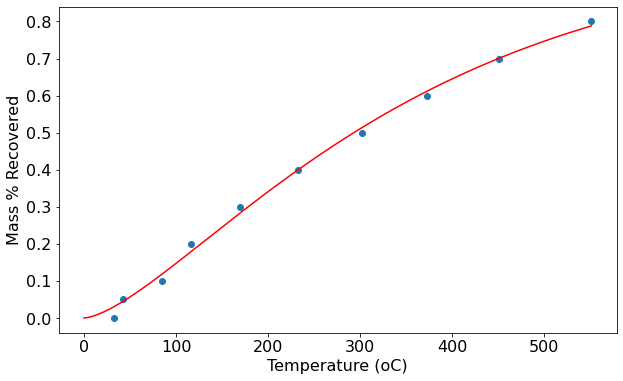

In [778]:
temp = crude_df["Temperature( oC )"]
distilled = [float(x) / 100 if x != "IBP" else 0 for x in list(crude_df.index)]
gamma_fit(temp, distilled);